# Dummy Classifer

<span>IIt is useful when developing machine learning models, to be modeling against a benchmark. If your new model cannot beat your benchmark model, then we are just wasting time and could be doing something more productive somewhere else. There may be a time where you do not have access to the previous model and don't have an obvious model for benchmarking. In this case, we can use a Dummy Model, which follows a heuristic on the input data. The dummy model would always "classify records as being from group 1", or "classify records at random from the target space/distribution," outputting our performance metrics afterward. This notebook will review the outputs that you can expect from a dummy classifier. The model can be useful when examining the results of your model and communicating that information to your team.</span>

**Dataset**

Poisonous Mushrooms Dataset: https://www.kaggle.com/uciml/mushroom-classification

### Import Preliminaries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import seaborn as sns
import warnings

from matplotlib import rcParams, gridspec
from sqlalchemy import create_engine
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting option
mpl.rcParams['figure.figsize'] = (9.0, 3.0)

# Set warning options
warnings.filterwarnings('ignore');

# Plot a confusion matrix function
def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None


# Plot a train and test confusion matrix together
def plot_confusion_normal(model, name, classes, train_x, train_y, 
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None

### Import Data

In [3]:
 # Set your local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'mushroom'

# Create a MySQLEngine
engine = create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
df = pd.read_sql(""" SELECT * FROM mushrooms""", engine).dropna(how='any', axis=0)
df.rename(columns={'class':'target'}, inplace=True)
# Some preprocessing on the data
df.head(10)

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,s,m


### Preprocess Data

In [4]:
# One-Hot Encoding Data, and Label Encoding the target values
targets = df.target.astype('category').cat.codes
targets = pd.Series(targets, name='target')
encoded_df = pd.get_dummies(df.drop('target', axis=1))
encoded_df = pd.concat([encoded_df, targets ], axis=1)

X = encoded_df.drop('target',axis=1).values
y = encoded_df.target.values

# Conduct a train-test-split on the data
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

### Data Overview

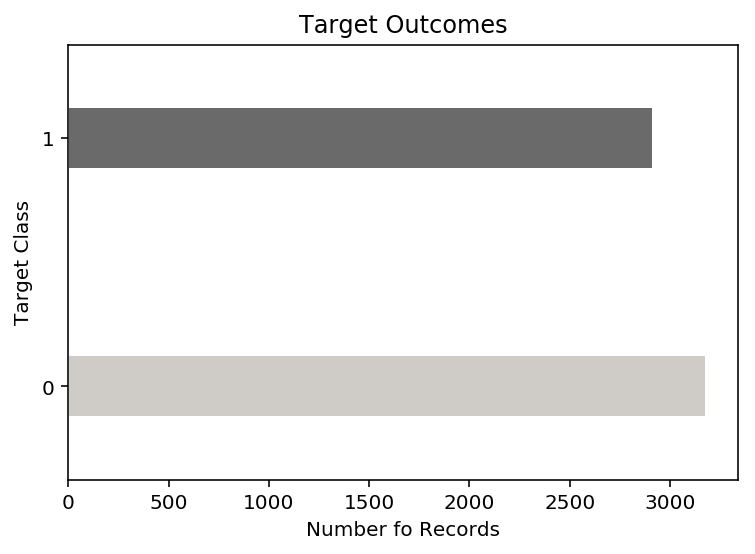

In [5]:
# Plot a barplot of the target clasees in our training set (1 = posinous, 0 = eatable by humans)
pd.Series(train_y).value_counts().plot.barh(grid=False, color=['#CFCCC7','#6A6A6A','#000000'], width=0.25,edgecolor='w')
plt.title('Target Outcomes')
plt.ylabel('Target Class')
plt.xlabel('Number fo Records');

### Constant Dummy Model

A constant model takes a constant value ("1") and tells us that everything is poisonous! The confusion matrix below is returning our performance metrics giving this heuristic. As you can see our cross-validation score is around 50%, and our True Positives, False Positives, True Negatives, and False Negatives are all around the same area.  This outcome makes sense given the class imbalance in our data as seen in the above bar plot.

Cross Validation Score: 0.50238


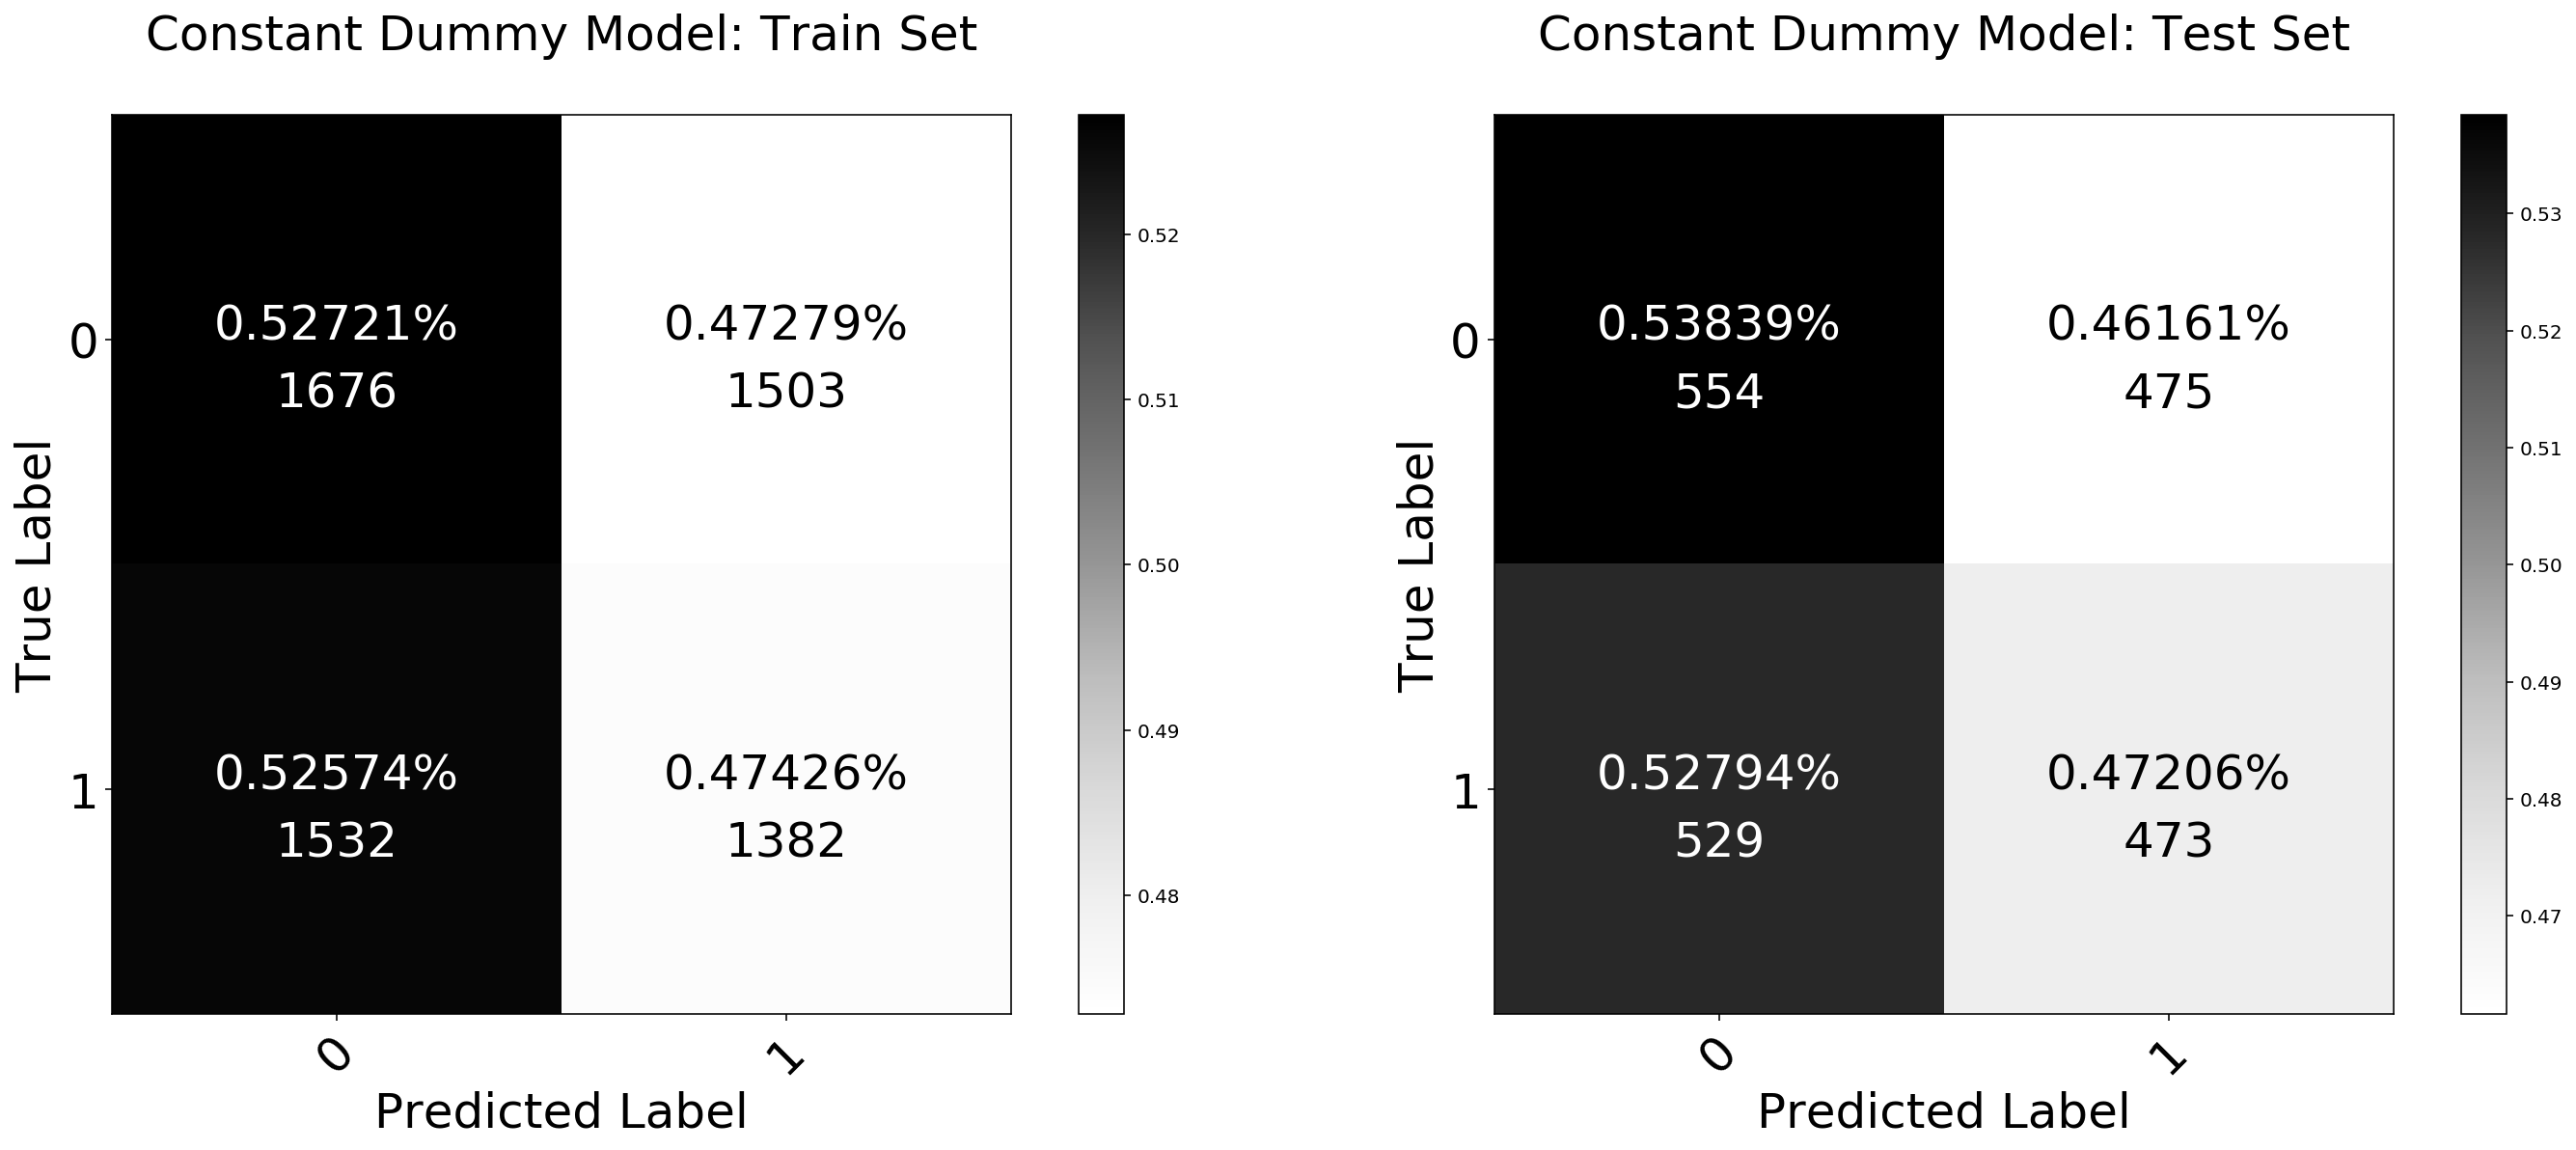

In [6]:
# Fit the intial logistic model 
constant_dm_model = DummyClassifier(constant=1)
constant_dm_model.fit(train_x, train_y);
scores = cross_val_score(constant_dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')
plot_confusion_normal(constant_dm_model, name ='Constant Dummy Model',
                      train_x=train_x, train_y=train_y, classes=[0,1],
                     test_x=test_x ,test_y=test_y, cmap=plt.cm.Greys)

### Stratified Dummy Model

A stratified dummy model looks at the overall distribution of classes in our target variable within our training set and then uses that information to assign a target value to each prediction randomly. Therefore in our case, it will notice that we have fewer poisonous mushrooms in our training set and adjust its prediction according. Again the results here are close to random.

Cross Validation Score: 0.50008


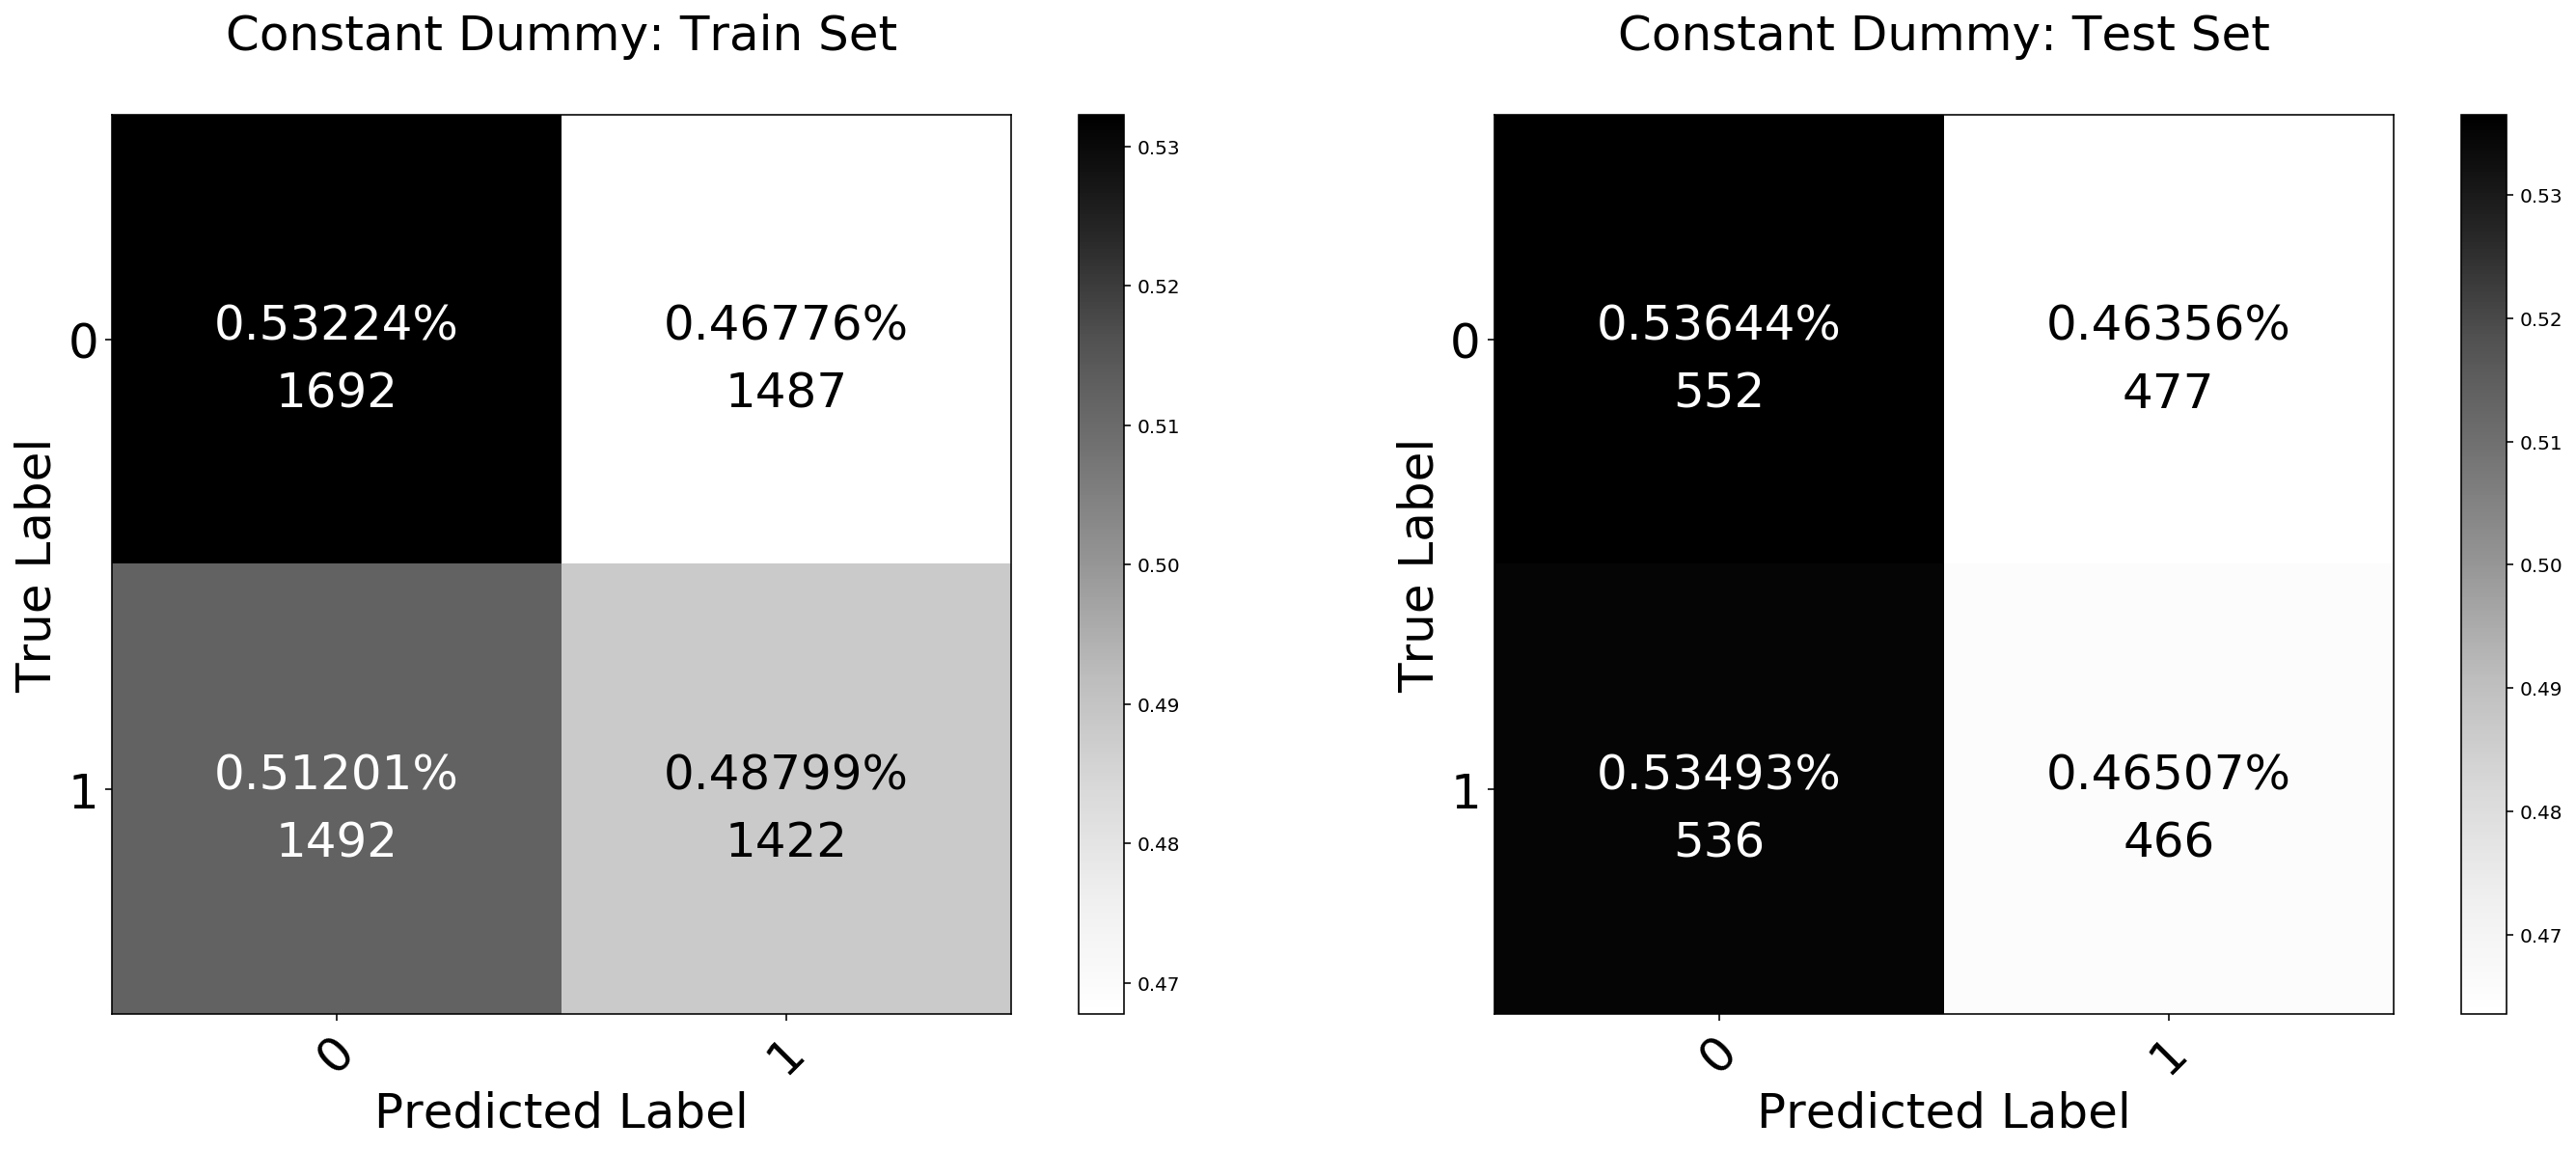

In [7]:
# Fit the intial logistic model 
stratified_dm_model = DummyClassifier(strategy='stratified')
stratified_dm_model.fit(train_x, train_y);
scores = cross_val_score(stratified_dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')
plot_confusion_normal(stratified_dm_model, name ='Constant Dummy',
                      train_x=train_x, train_y=train_y, classes=[0,1],
                     test_x=test_x ,test_y=test_y, cmap=plt.cm.Greys)

### Uniform Dummy Model

The uniform strategy is the same as the stratified strategy, except it does not adjust for class imbalance. Therefore this dummy model predicts a class for every observation at random from the full range 'f target classes.

Cross Validation Score: 0.50074


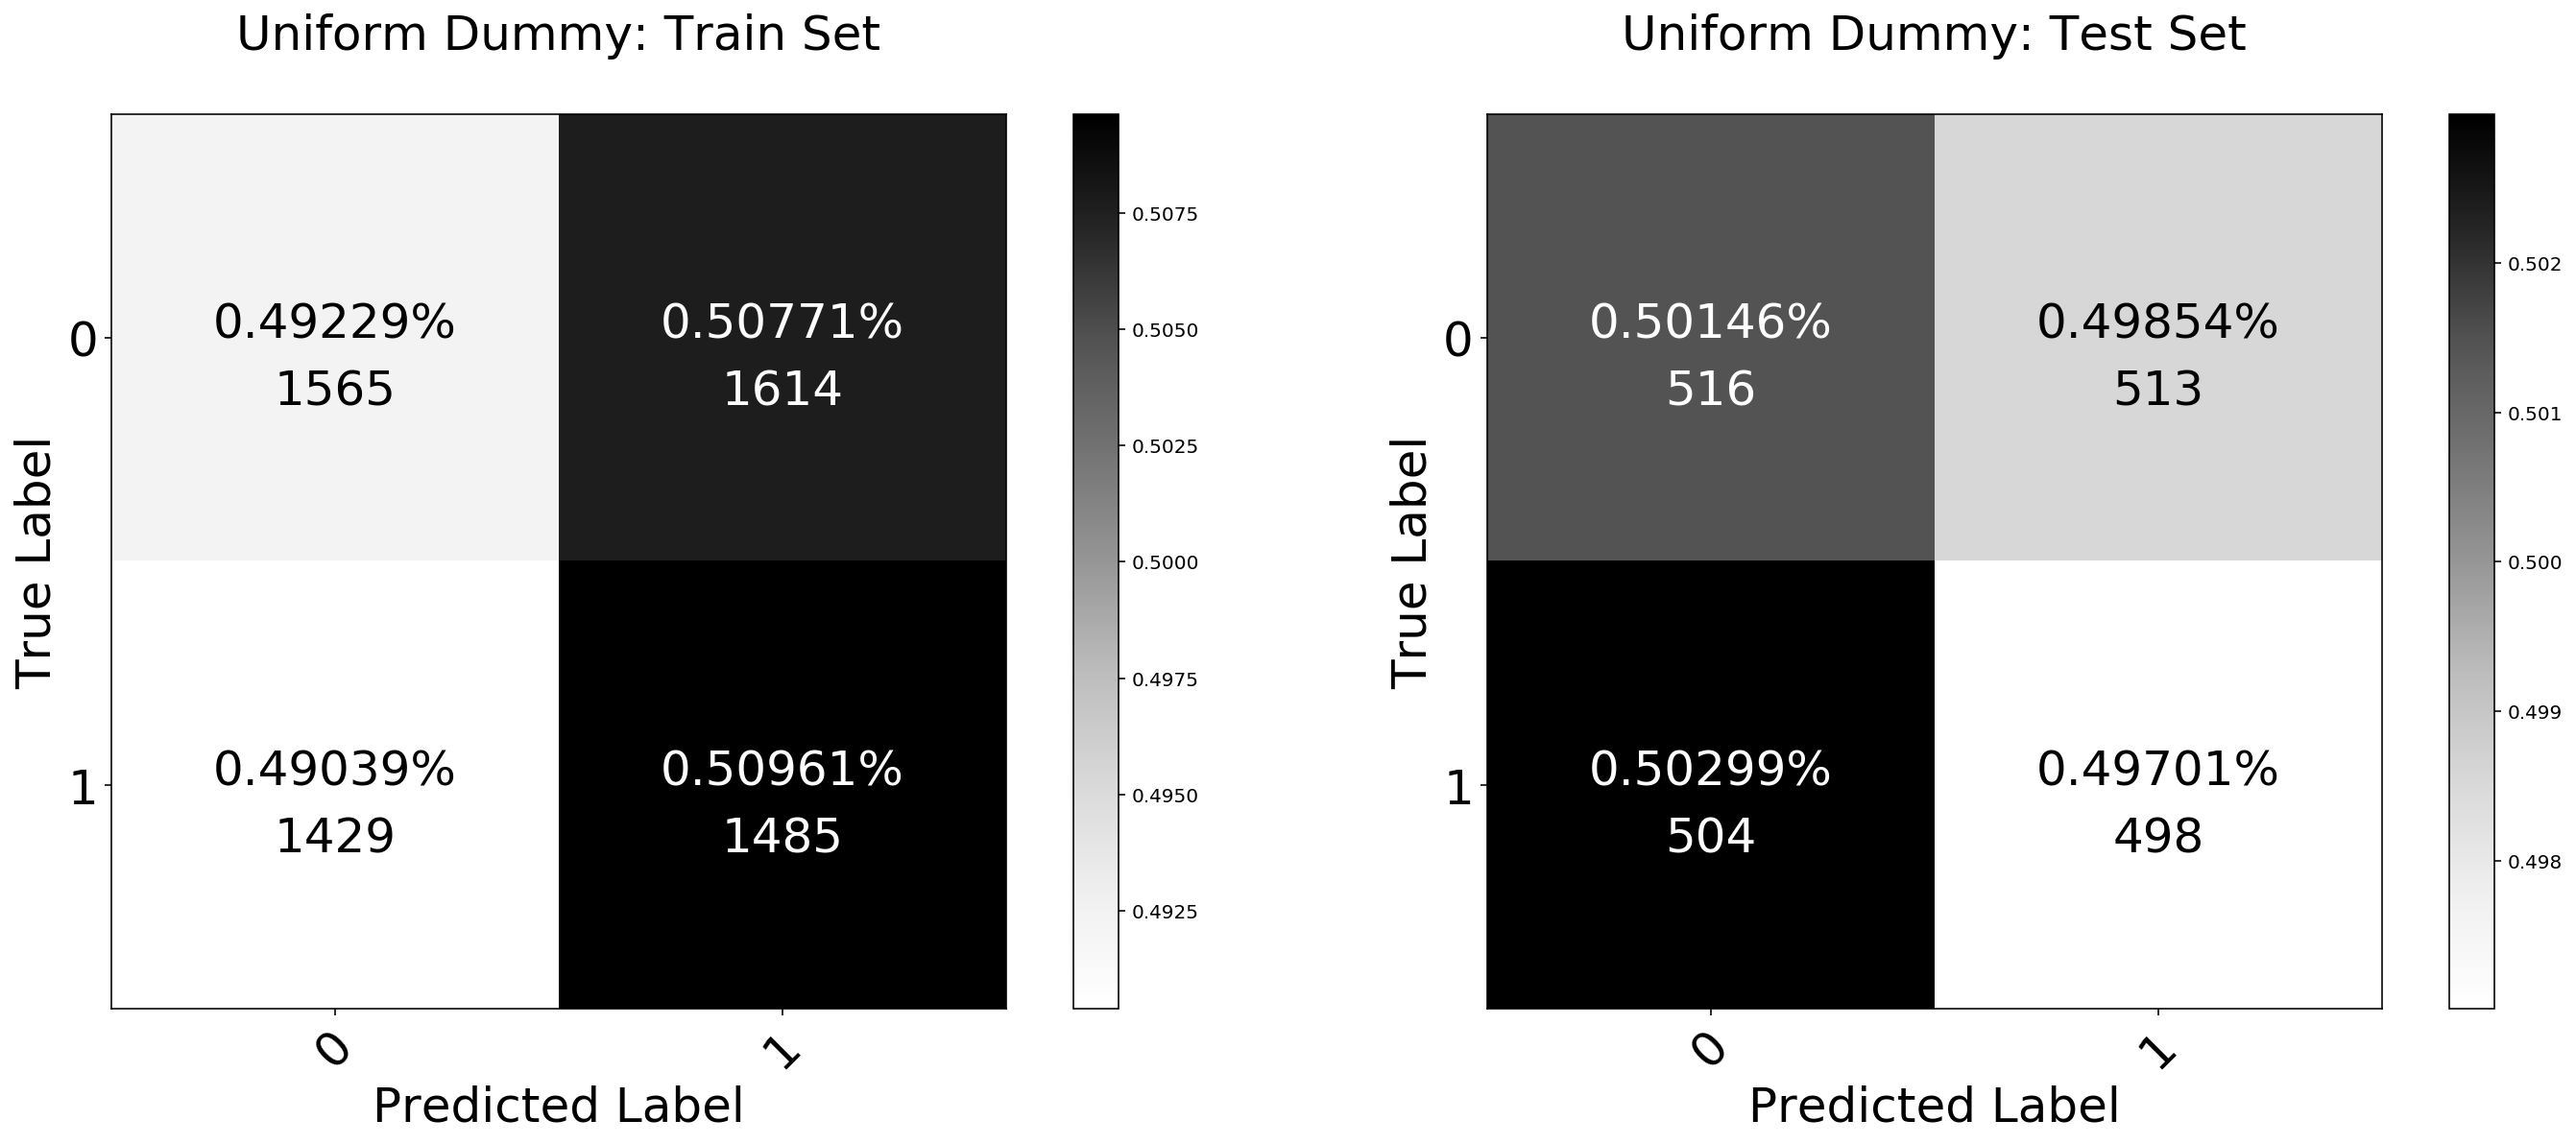

In [8]:
# Fit the intial logistic model 
random_dm_model = DummyClassifier(strategy='uniform')
random_dm_model.fit(train_x, train_y);
scores = cross_val_score(random_dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')
plot_confusion_normal(random_dm_model, name ='Uniform Dummy',
                      train_x=train_x, train_y=train_y, classes=[0,1],
                     test_x=test_x ,test_y=test_y, cmap=plt.cm.Greys)

### Prior Dummy Model

A prior strategy assumes that current observations must be related to the last training point, therefore assumes the target value of this observation is the True target value from the previous training point.

Cross Validation Score: 0.52175


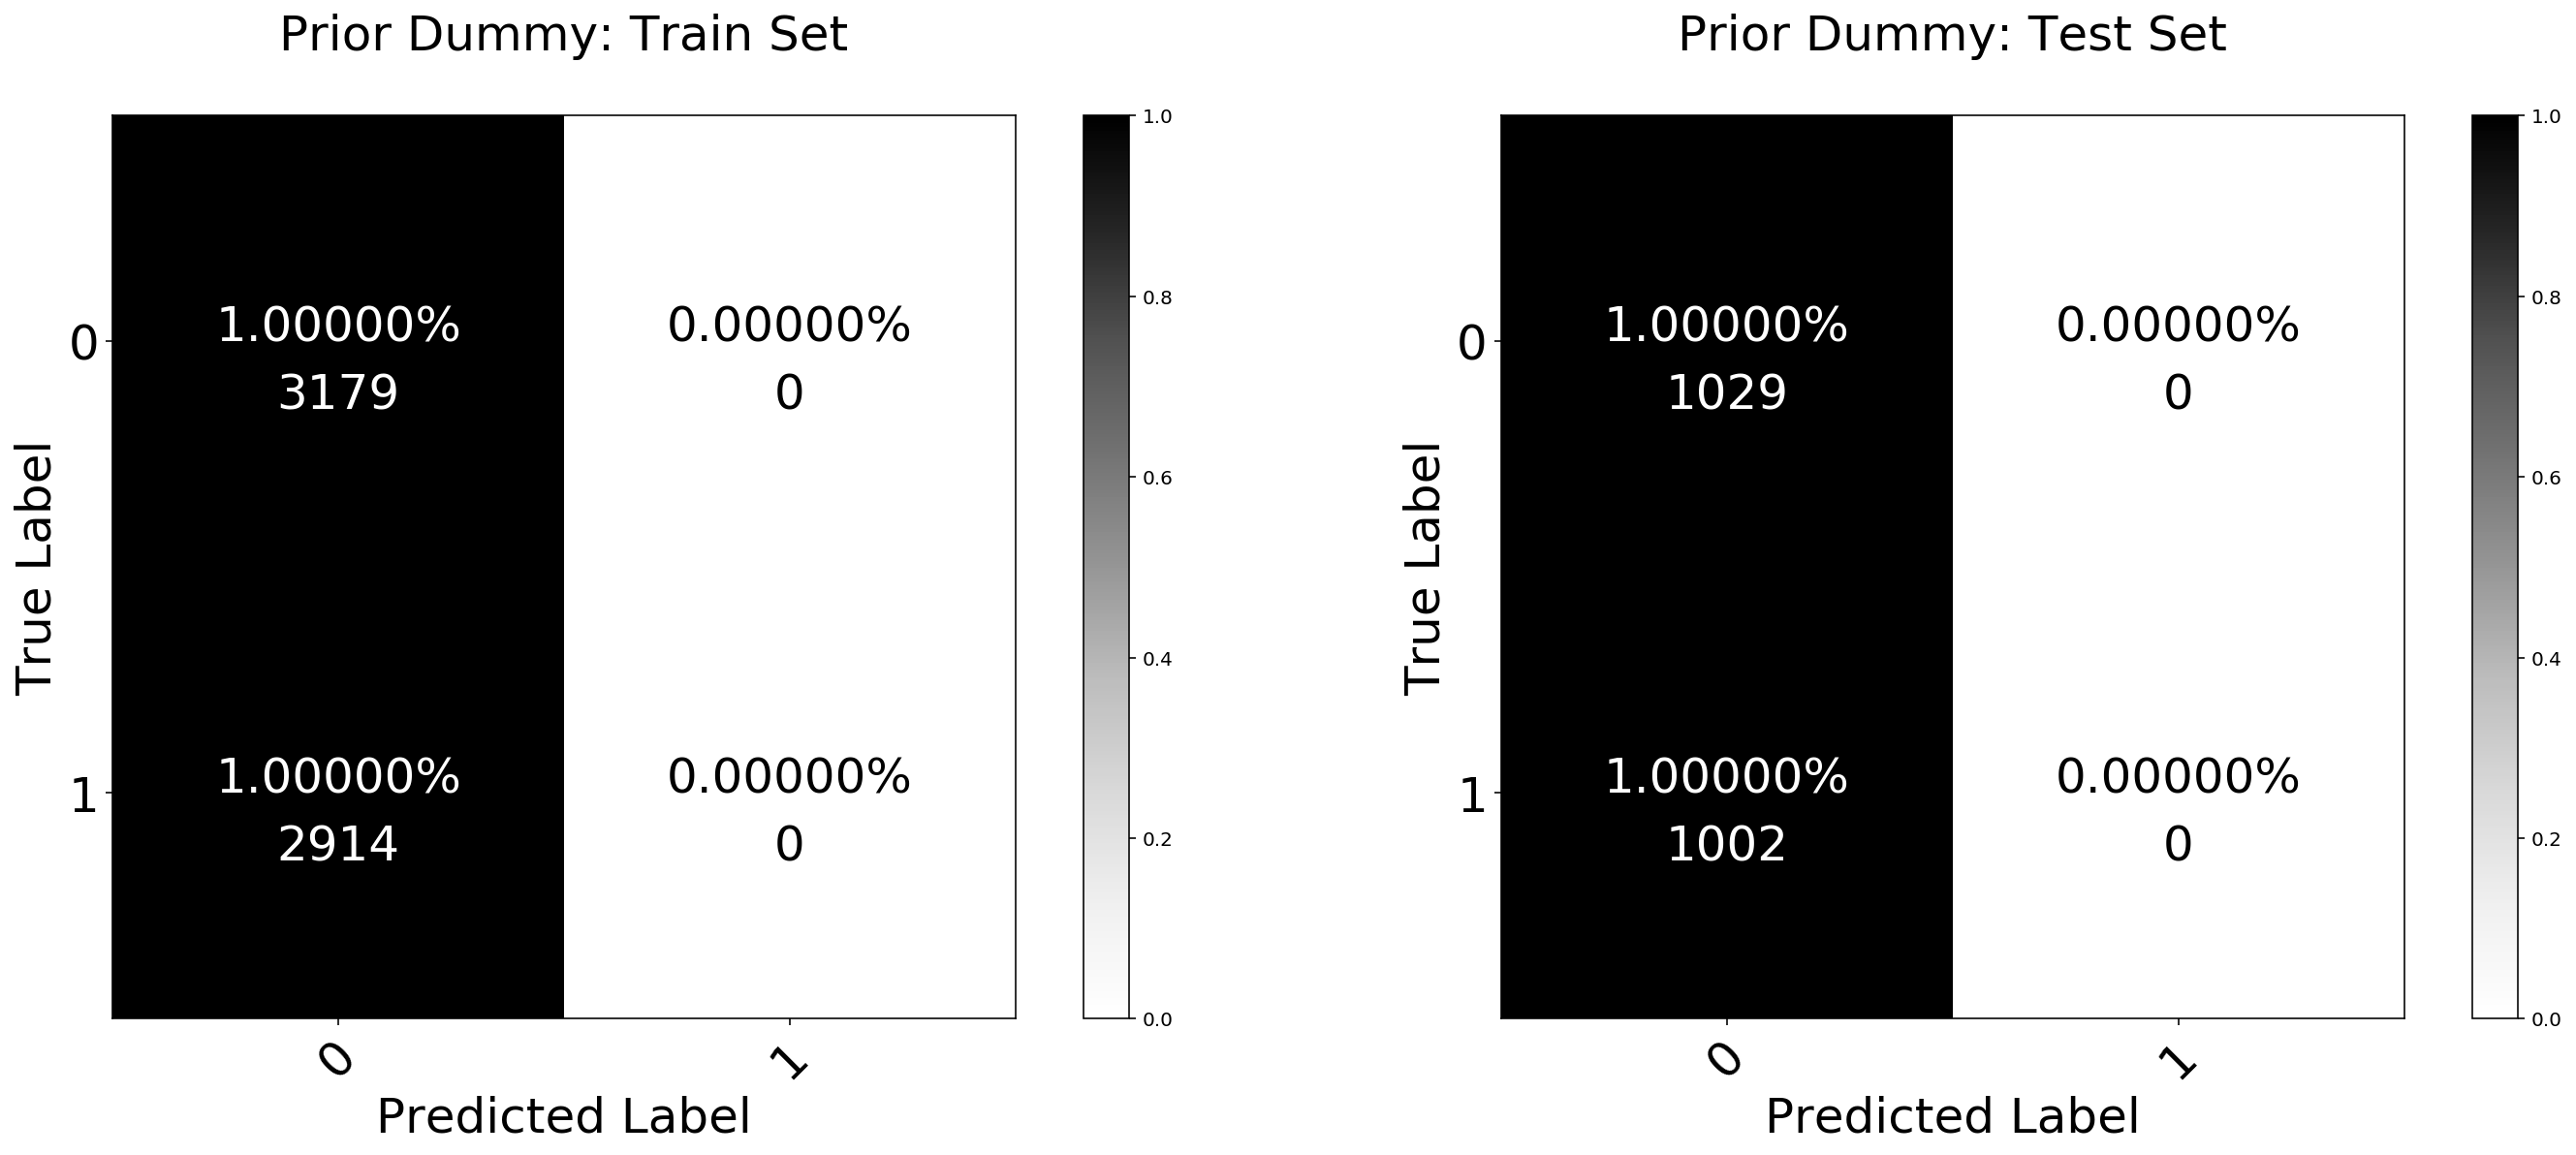

In [9]:
# Fit the intial logistic model 
prior_dm_model = DummyClassifier(strategy='prior')
prior_dm_model.fit(train_x, train_y);
scores = cross_val_score(prior_dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')
plot_confusion_normal(prior_dm_model, name ='Prior Dummy',
                      train_x=train_x, train_y=train_y, classes=[0,1],
                     test_x=test_x ,test_y=test_y, cmap=plt.cm.Greys)

### Logistic Regression

Depending on the problem, Any correctly trained model can beat the Sklearn dummy models. As you can see below, a simple logistic regression solves this problem very quickly. 

Cross Validation Score: 1.00000


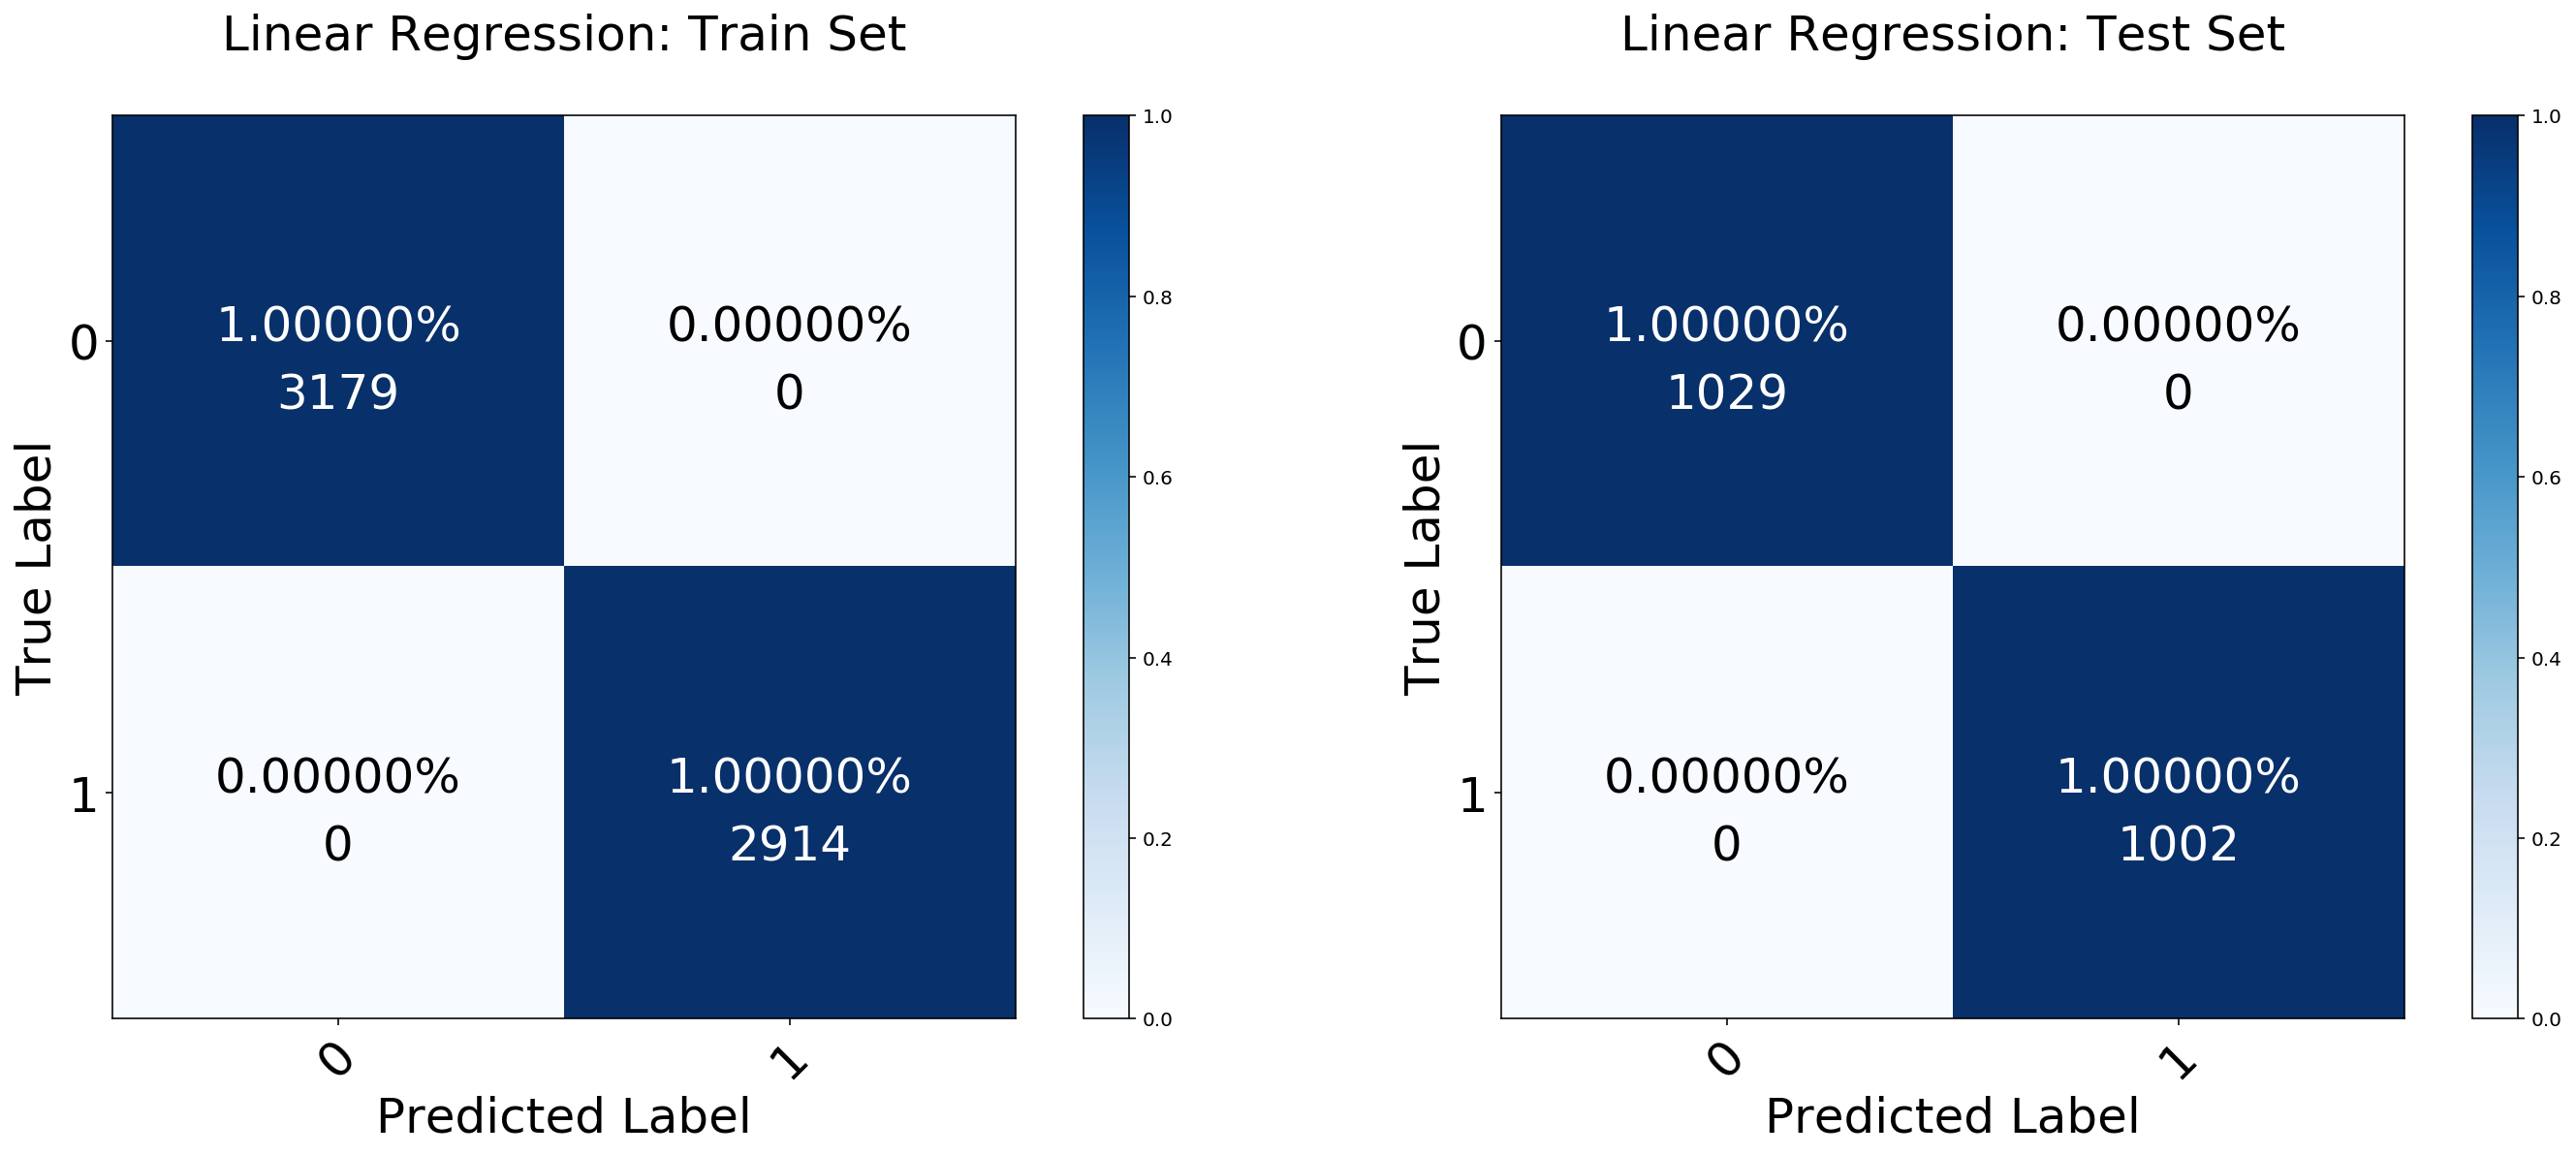

In [10]:
# Fit the intial logistic model 
lg_model = LogisticRegression(C=10000)
lg_model.fit(train_x, train_y);
scores = cross_val_score(lg_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')
plot_confusion_normal(lg_model, name ='Linear Regression',
                      train_x=train_x, train_y=train_y, classes=[0,1],
                     test_x=test_x ,test_y=test_y, cmap=plt.cm.Blues)

Author: Kavi Sekhon 